In [3]:
import os
import numpy as np
import cv2

from models import *

def gen_dir(folder):
    if not os.path.exists(folder):
        os.system('mkdir -p {}'.format(folder))

data_root = os.path.abspath('../')


dataset = 'bacterial'
model_name = ''
dataset_dir = data_root + '/datasets/{}'.format(dataset)
model_dir = data_root + '/datasets/{}/{}'.format(dataset, model_name)

gen_dir(dataset_dir)
gen_dir(model_dir)

In [4]:
import matplotlib.pyplot as plt
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    SMALL_SIZE = 24
    MEDIUM_SIZE = 24
    BIGGER_SIZE = 24

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    return ax

In [4]:
import scipy.ndimage as ndimage
img_index = 1
img = cv2.imread(img_dir + '{:03d}.png'.format(img_index), cv2.IMREAD_UNCHANGED)
dot = (cv2.imread(dot_dir + '{:03d}.png'.format(img_index), cv2.IMREAD_GRAYSCALE) > 0) * 1.
print(img.shape, dot.shape)
print(np.unique(dot))
print(np.sum(dot))
# generate density map
den_map = ndimage.gaussian_filter(dot, sigma=(3, 3), order=0)
print(den_map.shape, np.sum(den_map))

(256, 256, 3) (256, 256)
[0. 1.]
135.0
(256, 256) 135.0


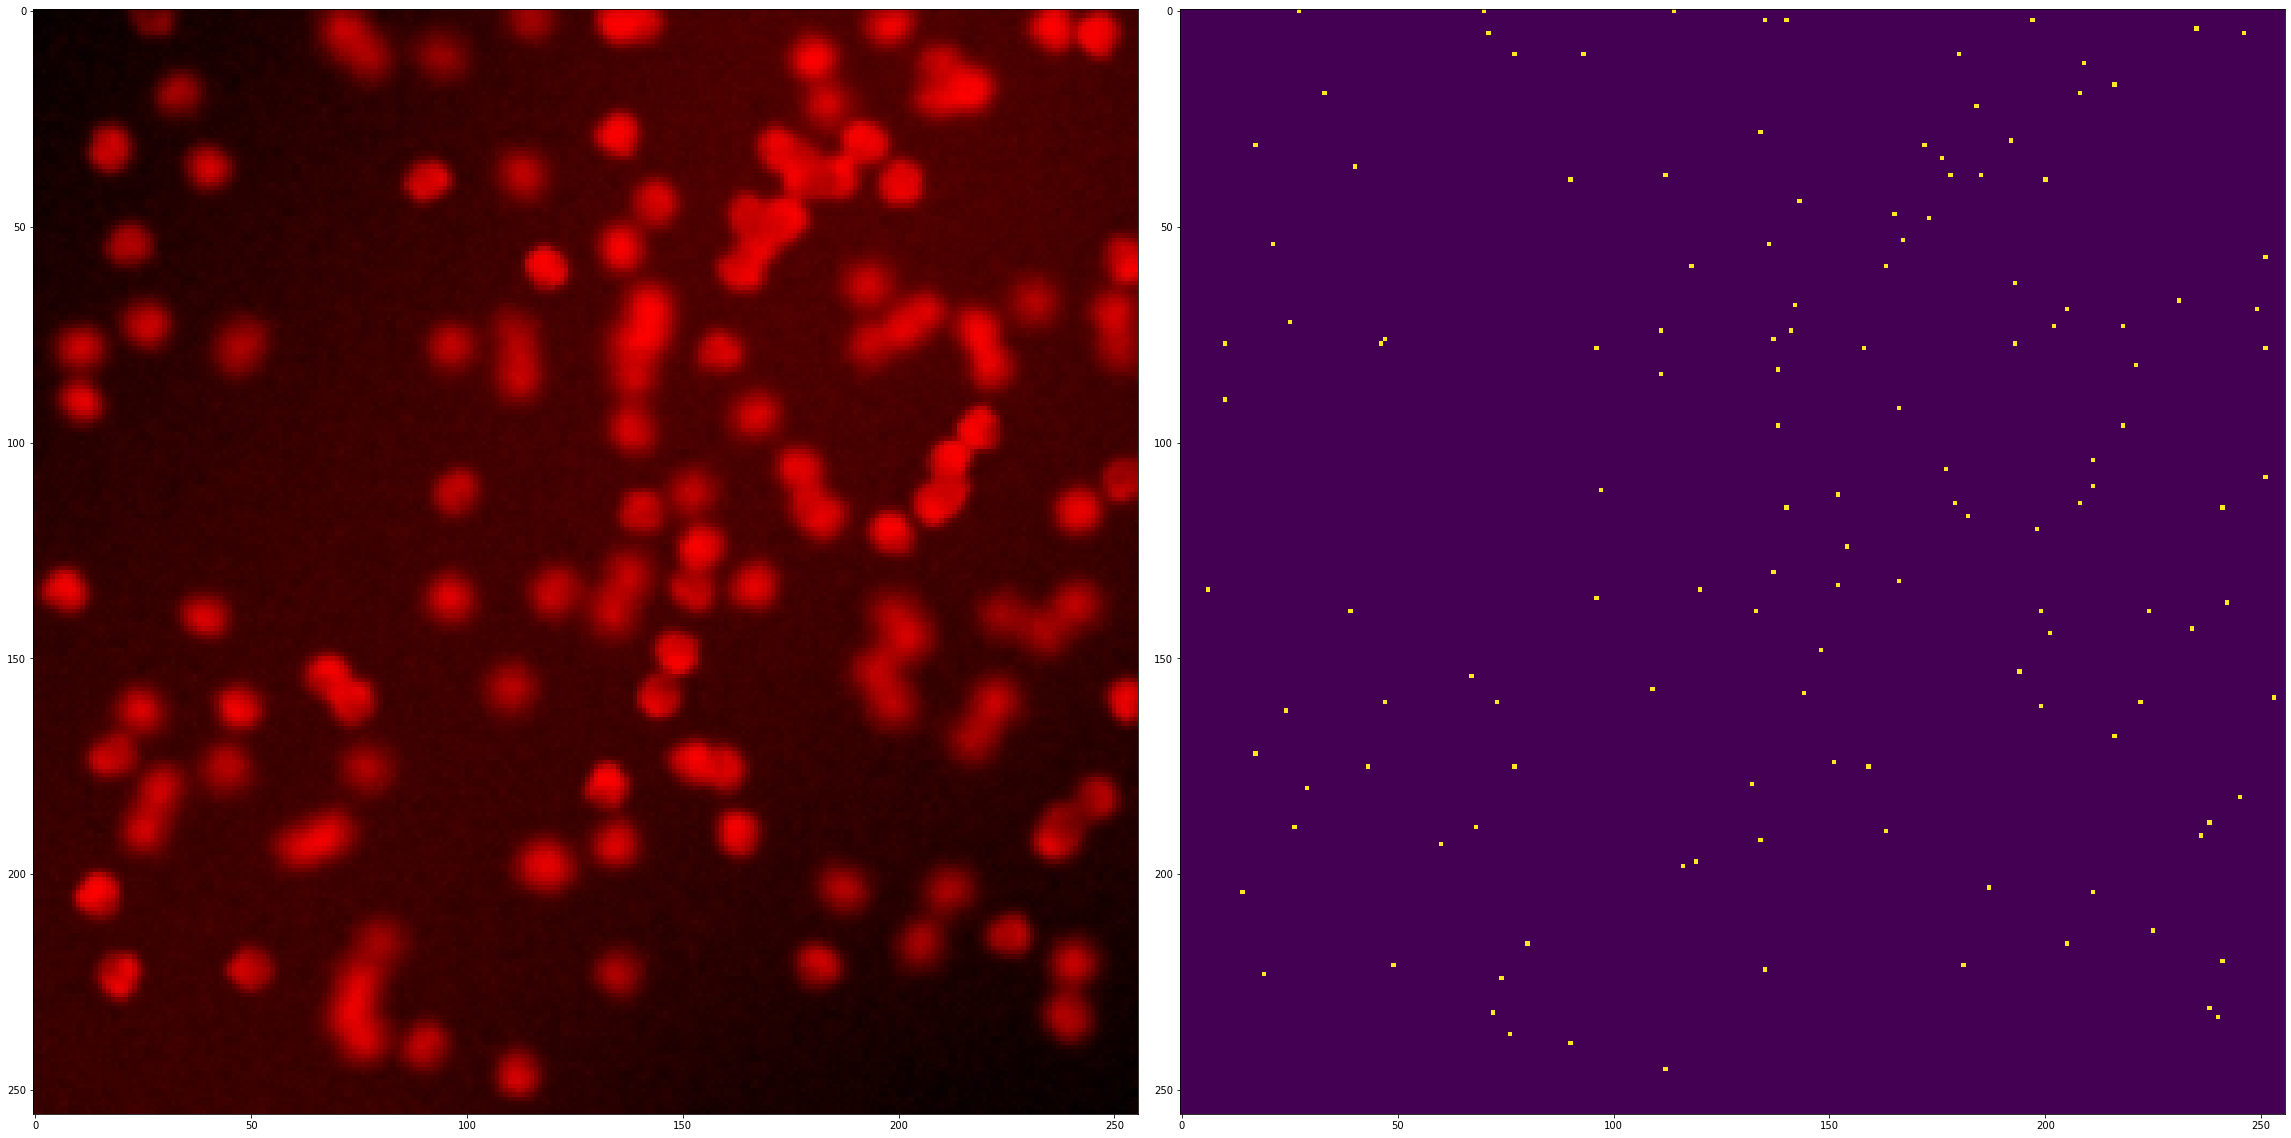

In [5]:
ax = get_ax(1, 2)
ax[0].imshow(img)
ax[1].imshow(dot)

In [6]:
dataset = 'bacterial'
net = 'FCRN_A'
lr = 1e-4
sigma = 3
batch_size = 32
if dataset == 'bacterial':
    dim = 256
    val_dim = 256
model_name = 'net-{}-bt-{}-lr-{}-sig-{}-dim-{}'.format(net, lr, batch_size, sigma, dim)
dataset_dir = data_root + '/datasets/{}'.format(dataset)
model_dir = data_root + '/models/{}/{}'.format(dataset, model_name)
print(dataset_dir)
print(model_dir)
gen_dir(dataset_dir)
gen_dir(model_dir)
sample_names = os.listdir(dataset_dir + '/images')
np.random.shuffle(sample_names)
n_train = int(len(sample_names) * 2./ 3)
train_samples = sample_names[:n_train]
valid_samples = sample_names[n_train:]
print(valid_samples)

/shared/einstein/Phantom/cell_counting/cell-counting/datasets/bacterial
/shared/einstein/Phantom/cell_counting/cell-counting/models/bacterial/net-FCRN_A-bt-0.0001-lr-32-sig-3-dim-256
['156.png', '181.png', '047.png', '040.png', '182.png', '109.png', '199.png', '077.png', '026.png', '152.png', '168.png', '177.png', '149.png', '171.png', '076.png', '082.png', '036.png', '117.png', '075.png', '163.png', '130.png', '043.png', '103.png', '054.png', '133.png', '018.png', '145.png', '010.png', '180.png', '068.png', '078.png', '023.png', '104.png', '108.png', '131.png', '081.png', '173.png', '092.png', '126.png', '190.png', '150.png', '140.png', '179.png', '086.png', '032.png', '118.png', '045.png', '049.png', '148.png', '164.png', '144.png', '031.png', '004.png', '102.png', '073.png', '069.png', '033.png', '166.png', '085.png', '194.png', '137.png', '016.png', '014.png', '013.png', '062.png', '064.png', '087.png']


In [7]:
import tensorflow as tf
import albumentations as A
class Dataset:
    """ datasets for model training and validation
    
    Args:
        img_dir (str): path to images folder
        dot_dir (str): path to dot annotation
        augmentation (albumentations.Compose): data transfromation pipeline
    """
    
    def __init__(
            self, 
            img_dir,
            dot_dir,
            sample_names,
            augmentation=None, 
    ):  
        self.images_fps = [os.path.join(img_dir, sn) for sn in sample_names]
        self.dot_fps = [os.path.join(dot_dir, sn) for sn in sample_names]
        self.ids = self.images_fps
        print('Load files: image {}, dot files: {}'.format(len(self.images_fps),len(self.dot_fps)))
        self.augmentation = augmentation
    
    def __getitem__(self, i):
        
        # load images and dot maps
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_COLOR)
        dot_map = (cv2.imread(self.dot_fps[i], cv2.IMREAD_GRAYSCALE) > 0) * 1.

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=dot_map)
            image, dot_map = sample['image'], sample['mask']

        # generate density map
        den_map = ndimage.gaussian_filter(dot_map, sigma=(3, 3), order=0) * 100

        # apply preprocessing
        # if self.preprocessing:
        #     sample = self.preprocessing(image=image, mask=mask)
        #     image, mask = sample['image'], sample['mask']

        return image, np.expand_dims(den_map, axis = -1)
        
    def __len__(self):
        return len(self.ids)
    

class Dataloder(tf.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return (batch[0], batch[1])
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation(dim):
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.PadIfNeeded(min_height=dim, min_width=dim, always_apply=True, border_mode=0),
        A.RandomCrop(height=dim, width=dim, always_apply=True),]
    return A.Compose(train_transform)


def get_validation_augmentation(dim = 256):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(dim, dim)
    ]
    return A.Compose(test_transform)


In [8]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
lr = 1e-4
batch_size = 32
model = globals()[net](input_shape = (None, None, 3))
optim = tf.keras.optimizers.Adam(lr)
loss = tf.keras.losses.MSE
from tensorflow.keras import backend as K

def mce(y_true, y_pred): 
    x = tf.reduce_sum(y_true, axis = [1, 2, 3])
    y = tf.reduce_sum(y_pred, axis = [1, 2, 3])
    return tf.reduce_mean(tf.math.abs(x - y)) / 100.
    
metrics = [mce]

train_dataset = Dataset(img_dir = img_dir, 
                        dot_dir = dot_dir, 
                        sample_names = train_samples, 
                        augmentation= get_training_augmentation(dim = dim)
                        )
valid_dataset = Dataset(img_dir = img_dir, 
                        dot_dir = dot_dir, 
                        sample_names = valid_samples, 
                        augmentation= get_training_augmentation(dim = val_dim)
                        )
print(train_dataset[0][0].shape, train_dataset[0][1].shape, 'count: {:.2f}'.format(train_dataset[0][1].sum()))

train_dataloader = Dataloder(train_dataset, batch_size = batch_size, shuffle = True)
valid_dataloader = Dataloder(valid_dataset, batch_size = 1, shuffle = False)
print(train_dataloader[0][0].shape, train_dataloader[0][1].shape, 'count: {:.2f}'.format(train_dataloader[0][1].sum()))

callbacks = [
			tf.keras.callbacks.ModelCheckpoint(model_dir+'/best_model-{epoch:03d}.h5', monitor='val_mce', save_weights_only=True, save_best_only=True, mode='min'),
			tf.keras.callbacks.ReduceLROnPlateau(factor = 0.9),
]

epochs = 1000
model.compile(optim, loss, metrics)
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=epochs, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Load files: image 133, dot files: 133
Load files: image 67, dot files: 67
(256, 256, 3) (256, 256, 1) count: 12200.00
(32, 256, 256, 3) (32, 256, 256, 1) count: 587400.00


2021-12-19 05:20:26.114290: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-12-19 05:20:26.177058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 05:20:26.177609: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:02:00.0
2021-12-19 05:20:26.258431: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-12-19 05:20:26.375932: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-12-19 05:20:26.398374: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library

Epoch 1/1000


2021-12-19 05:20:28.548363: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-12-19 05:20:28.979032: W tensorflow/stream_executor/cuda/redzone_allocator.cc:312] Not found: ./bin/ptxas not found
Relying on driver to perform ptx compilation. This message will be only logged once.
2021-12-19 05:20:29.703867: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


4/4 [==============================] - 41s 10s/step - loss: 0.3938 - mce: 76.7787 - val_loss: 0.2291 - val_mce: 69.1655
Epoch 2/1000
4/4 [==============================] - 1s 336ms/step - loss: 0.1952 - mce: 57.4077 - val_loss: 0.2126 - val_mce: 94.8300
Epoch 3/1000
4/4 [==============================] - 1s 335ms/step - loss: 0.1444 - mce: 50.6587 - val_loss: 0.2419 - val_mce: 170.3143
Epoch 4/1000
4/4 [==============================] - 1s 336ms/step - loss: 0.1201 - mce: 42.0865 - val_loss: 0.4191 - val_mce: 315.5972
Epoch 5/1000
4/4 [==============================] - 2s 481ms/step - loss: 0.1050 - mce: 35.4249 - val_loss: 0.5359 - val_mce: 381.7851
Epoch 6/1000
4/4 [==============================] - 1s 336ms/step - loss: 0.0943 - mce: 30.0984 - val_loss: 0.6475 - val_mce: 431.8305
Epoch 7/1000
4/4 [==============================] - 1s 335ms/step - loss: 0.0869 - mce: 24.5655 - val_loss: 0.6333 - val_mce: 424.4356
Epoch 8/1000
4/4 [==============================] - 1s 336ms/step - los

(1200, 1200, 3) (1200, 1200) [  0 255] 90780
356.0


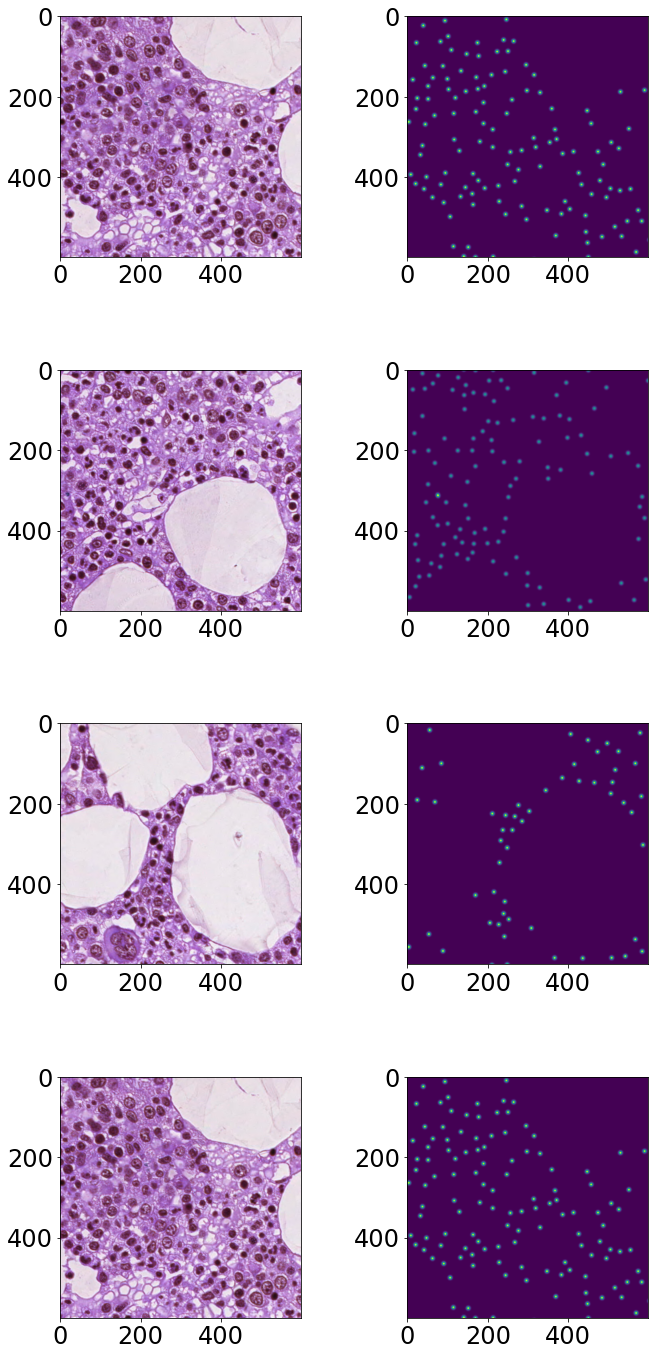

In [16]:
import scipy.ndimage as ndimage
trg_data = 'BMC'
src_data = 'BM_dataset_MICCAI2015'
src_dir = data_root + '/datasets/{}'.format(src_data)
trg_dir = data_root + '/datasets/{}'.format(trg_data)
img_dir = trg_dir + '/images/'
dot_dir = trg_dir + '/dots/'
gen_dir(img_dir)
gen_dir(dot_dir)
fns = os.listdir(src_dir + '/source')
src_img_dir = os.path.join(src_dir, 'source')
src_dot_dir = os.path.join(src_dir, 'annotations')
fn = fns[0]
# for fn in fns:
img_file = src_img_dir + '/' + fn
dot_file = src_dot_dir + '/' + fn.replace('.png', '_dots.png')
image = cv2.imread(img_file, cv2.IMREAD_COLOR)
dot_map = cv2.imread(dot_file, cv2.IMREAD_GRAYSCALE)
ax = get_ax(4, 2, 5)
# ax[0].imshow(image)
# ax[1].imshow(dot_map)
print(image.shape, dot_map.shape, np.unique(dot_map), dot_map.sum())
dot = 1.0 * (dot_map > 0)
den_map = ndimage.gaussian_filter(dot, sigma=(3, 3), order=0) * 100
print(dot.sum())
size = int(image.shape[0] / 2)
im1 = image[:size, :size, :]; dot1 = den_map[:size, :size]
im2 = image[size:, :size, :]; dot2 = den_map[size:, :size]
im3 = image[:size, size:, :]; dot3 = den_map[:size, size:]
im4 = image[:size, :size, :]; dot4 = den_map[:size, :size]
# cv2.imwrite(img_dir + '/' + fn.replace('.png', '_01.png'), im1)
# cv2.imwrite(img_dir + '/' + fn.replace('.png', '_02.png'), im2)
# cv2.imwrite(img_dir + '/' + fn.replace('.png', '_03.png'), im3)
# cv2.imwrite(img_dir + '/' + fn.replace('.png', '_04.png'), im4)
# cv2.imwrite(dot_dir + '/' + fn.replace('.png', '_01.png'), dot1)
# cv2.imwrite(dot_dir + '/' + fn.replace('.png', '_02.png'), dot2)
# cv2.imwrite(dot_dir + '/' + fn.replace('.png', '_03.png'), dot3)
# cv2.imwrite(dot_dir + '/' + fn.replace('.png', '_04.png'), dot4)
ax[0, 0].imshow(im1)
ax[0, 1].imshow(dot1)
ax[1, 0].imshow(im2)
ax[1, 1].imshow(dot2)
ax[2, 0].imshow(im3)
ax[2, 1].imshow(dot3)
ax[3, 0].imshow(im4)
ax[3, 1].imshow(dot4)

In [17]:
import scipy.ndimage as ndimage
trg_data = 'BMC'
src_data = 'BM_dataset_MICCAI2015'
src_dir = data_root + '/datasets/{}'.format(src_data)
trg_dir = data_root + '/datasets/{}'.format(trg_data)
img_dir = trg_dir + '/images/'
dot_dir = trg_dir + '/dots/'
gen_dir(img_dir)
gen_dir(dot_dir)
fns = os.listdir(src_dir + '/source')
src_img_dir = os.path.join(src_dir, 'source')
src_dot_dir = os.path.join(src_dir, 'annotations')
fn = fns[0]
for fn in fns:
    img_file = src_img_dir + '/' + fn
    dot_file = src_dot_dir + '/' + fn.replace('.png', '_dots.png')
    image = cv2.imread(img_file, cv2.IMREAD_COLOR)
    dot_map = cv2.imread(dot_file, cv2.IMREAD_GRAYSCALE)
    print(image.shape, dot_map.shape, np.unique(dot_map), dot_map.sum())
    size = int(image.shape[0] / 2)
    im1 = image[:size, :size, :]; dot1 = dot_map[:size, :size]
    im2 = image[size:, :size, :]; dot2 = dot_map[size:, :size]
    im3 = image[:size, size:, :]; dot3 = dot_map[:size, size:]
    im4 = image[:size, :size, :]; dot4 = dot_map[:size, :size]
    cv2.imwrite(img_dir + '/' + fn.replace('.png', '_01.png'), im1)
    cv2.imwrite(img_dir + '/' + fn.replace('.png', '_02.png'), im2)
    cv2.imwrite(img_dir + '/' + fn.replace('.png', '_03.png'), im3)
    cv2.imwrite(img_dir + '/' + fn.replace('.png', '_04.png'), im4)
    cv2.imwrite(dot_dir + '/' + fn.replace('.png', '_01.png'), dot1)
    cv2.imwrite(dot_dir + '/' + fn.replace('.png', '_02.png'), dot2)
    cv2.imwrite(dot_dir + '/' + fn.replace('.png', '_03.png'), dot3)
    cv2.imwrite(dot_dir + '/' + fn.replace('.png', '_04.png'), dot4)

(1200, 1200, 3) (1200, 1200) [  0 255] 90780
(1200, 1200, 3) (1200, 1200) [  0 255] 74460
(1200, 1200, 3) (1200, 1200) [  0 255] 105060
(1200, 1200, 3) (1200, 1200) [  0 255] 107865
(1200, 1200, 3) (1200, 1200) [  0 255] 75225
(1200, 1200, 3) (1200, 1200) [  0 255] 102765
(1200, 1200, 3) (1200, 1200) [  0 255] 92820
(1200, 1200, 3) (1200, 1200) [  0 255] 115260
(1200, 1200, 3) (1200, 1200) [  0 255] 106845
(1200, 1200, 3) (1200, 1200) [  0 255] 100215
(1200, 1200, 3) (1200, 1200) [  0 255] 100980
